# Environment

In [1]:
import higlass
from higlass.client import View, Track, CombinedTrack
from higlass.tilesets import cooler, beddb, chromsizes, bigwig, Tileset
import clodius
from cooler import Cooler, create_cooler
import os
import os.path as path
import pandas as pd
import numpy as np
import itertools
import negspy.coordinates as nc
import matplotlib.pyplot as plt
import scipy.stats as stats

# Load annotations

In [2]:
genes = beddb("../2019-10-24_higlass/Data/hg38/gene-annotations-hg38.beddb")
chrom_sizes = chromsizes("../2019-10-24_higlass/hg38.chrom.sizes")
label_font_size = 18
chr_label_size = 30
annots_size = 150

chrom_labels = {
    p: Track(
        track_type=l + "-chromosome-labels",
        tileset=chrom_sizes,
        position=p,
        height=chr_label_size,
        width=chr_label_size,
        options={
            "fontSize": label_font_size,
            "showMousePosition": True,
        },
    ) for p, l in zip(["top", "bottom", "left", "right"], ["horizontal", "horizontal", "vertical", "vertical"])
}

gene_annots = {
    p: Track(
        track_type=l + "-gene-annotations",
        tileset=genes,
        position=p,
        height=annots_size,
        width=annots_size,
        options={
            "fontSize": label_font_size,
            "showMousePosition": True,
        },
    ) for p, l in zip(["top", "bottom", "left", "right"], ["horizontal", "horizontal", "vertical", "vertical"])
}

hg38 = nc.get_chrominfo("hg38")

# Data
## Contact matrices

In [3]:
tumour_metadata = pd.read_csv(path.join("..", "..", "Data", "External", "LowC_Samples_Data_Available.tsv"), sep="\t", header=0)
tumour_metadata = tumour_metadata.loc[tumour_metadata.Include == "Yes", :]
tumour_metadata["SampleID"] = ["PCa" + str(i) for i in tumour_metadata["Sample ID"]]

tumour_samples = tumour_metadata["SampleID"].tolist()
t2e_samples = tumour_metadata.loc[tumour_metadata["T2E Status"] == "Yes", "SampleID"].tolist()
nont2e_samples = tumour_metadata.loc[tumour_metadata["T2E Status"] == "No", "SampleID"].tolist()

benign_metadata = pd.read_csv(path.join("..", "..", "Data", "Raw", "191220_A00827_0104_AHMW25DMXX_HiC", "config.tsv"), sep="\t", header=0)
benign_metadata = benign_metadata.loc[benign_metadata.Include == "Yes", :]
benign_samples = benign_metadata["Sample"].tolist()

cell_line_metadata = pd.read_csv(path.join("..", "..", "Data", "External", "Rhie_2019", "config.tsv"), sep="\t", header=0)
cell_line_samples = cell_line_metadata["Run_Accession"].tolist()

all_samples = tumour_samples + benign_samples + cell_line_samples
metadata = pd.read_csv(path.join("..", "2020-01-15_TAD-aggregation", "config.tsv"), sep="\t", index_col=False, header=0)
cooler_files = (
    [path.join("..", "..", "Data", "Processed", "2019-06-18_PCa-LowC-sequencing", "Contacts", s + ".mcool") for s in tumour_samples + benign_samples]
    + [path.join("..", "..", "Data", "External", "Rhie_2019", "Contacts", s + ".mcool") for s in cell_line_samples]
)
lowc_tilesets = {s: cooler(f) for s, f in zip(all_samples, cooler_files)}

resolutions = [
    1000, 2000, 3000, 4000, 5000,
    10000, 20000, 30000, 40000, 50000,
    100000, 200000, 300000, 400000, 500000,
    1000000, 2000000, 3000000, 4000000, 5000000
][::-1]

min_resolution = 40000
heatmap_size = 500
colour_range = [
    "rgba(65, 105, 225, 1.0)",
    "rgba(255, 250, 250, 1.0)",
    # "rgba(240, 128, 128, 1.0)",
    "rgba(255, 25, 25, 1.0)"
]
lowc_heatmaps = {
    s: {
        p: Track(
            track_type=l + "heatmap",
            position=p,
            tileset=lowc_tilesets[s],
            filetype="cooler",
            height=heatmap_size,
            options={
                "maxZoom": str(resolutions.index(min_resolution)),
                "colorbarPosition": "topRight",
                "showMousePosition": True,
                "name": metadata.loc[metadata["SampleID"] == s, "Label"].values[0],
                "colorRange": colour_range,
            },
        ) for p, l in zip(
            ["top", "bottom", "left", "right", "center"],
            ["horizontal-", "horizontal-", "vertical-", "vertical-", ""]
        )
    } for s in all_samples
}

## H3K27ac ChIP-seq

In [4]:
line_height = 150
chip_files = {s: path.join("..", "..", "Data", "Processed", "2019-05-03_PCa-H3K27ac-peaks", "Peaks", s + "_FE.sorted.filtered.bw") for s in tumour_samples}
chip_tilesets = {s: bigwig(f) for s, f in chip_files.items()}
chip = {
    s: {
        p: Track(
            track_type=t + "-bar",
            position=p,
            tileset=ts,
            filetype="vector",
            height=line_height,
            width=line_height,
            options={
                "showMousePosition": True,
                "name": metadata.loc[metadata["SampleID"] == s, "Label"].values[0] + " H3K27ac",
                "barFillColor": metadata.loc[metadata["SampleID"] == s, "Sample_Colour"].values[0],
            },
        ) for p, t in zip(["top", "bottom", "left", "right"], ["horizontal", "horizontal", "vertical", "vertical"])
    } for s, ts in chip_tilesets.items()
}

chip_line = {
    s: {
        p: Track(
            track_type=t + "-line",
            position=p,
            tileset=ts,
            filetype="vector",
            height=line_height,
            width=line_height,
            options={
                "showMousePosition": True,
                "name": metadata.loc[metadata["SampleID"] == s, "Label"].values[0] + " H3K27ac",
                "lineStrokeColor": metadata.loc[metadata["SampleID"] == s, "Sample_Colour"].values[0],
            },
        ) for p, t in zip(["top", "bottom", "left", "right"], ["horizontal", "horizontal", "vertical", "vertical"])
    } for s, ts in chip_tilesets.items()
}

peak_files = {s: path.join("..", "..", "Data", "Processed", "2019-05-03_PCa-H3K27ac-peaks", "Tracks", s + "_peaks.beddb") for s in tumour_samples}
peak_tilesets = {s: beddb(f) for s, f in peak_files.items()}
peaks = {
    s: {
        p: Track(
            track_type=t + "bedlike",
            position=p,
            tileset=ts,
            filetype="beddb",
            options={
                "showMousePosition": True,
                "name": metadata.loc[metadata["SampleID"] == s, "Label"].values[0] + " H3K27ac Peaks",
                "fillColor": metadata.loc[metadata["SampleID"] == s, "Sample_Colour"].values[0],
            },
        ) for p, t in zip(["top", "bottom", "left", "right"], ["", "", "vertical-", "vertical-"])
    } for s, ts in peak_tilesets.items()
}

core_files = {s: path.join("..", "..", "Data", "Processed", "2019-05-03_PCa-H3K27ac-peaks", "COREs", s + ".cores.beddb") for s in tumour_samples}
core_tilesets = {s: beddb(f) for s, f in core_files.items()}
cores = {
    s: {
        p: Track(
            track_type=t + "bedlike",
            position=p,
            tileset=ts,
            filetype="beddb",
            options={
                "showMousePosition": True,
                "name": metadata.loc[metadata["SampleID"] == s, "Label"].values[0] + " COREs",
                "fillColor": metadata.loc[metadata["SampleID"] == s, "Sample_Colour"].values[0],
            },
        ) for p, t in zip(["top", "bottom", "left", "right"], ["", "", "vertical-", "vertical-"])
    } for s, ts in core_tilesets.items()
}


## Load breakpoints

In [5]:
BREAK_DIR = path.join("..", "2020-02-19_chromoplexy")
breaks = pd.read_csv(
    path.join(BREAK_DIR, "Graphs", "sv-breakpoints.paired.tsv"),
    sep="\t",
    header=0,
    index_col=False,
)

break_files_1D = {s: path.join(BREAK_DIR, "Tracks", s + ".breaks.beddb") for s in tumour_samples}
break_tilesets_1D = {
    s: beddb(
        v,
        name=metadata.loc[metadata["SampleID"] == s, "Label"].values[0] + " Breaks"
    ) for s, v in break_files_1D.items()
}
break_tracks_1D = {
    s: {
        p: Track(
            track_type=t + "bedlike",
            position=p,
            tileset=break_tilesets_1D[s],
            filetype="beddb",
            options={
                "showMousePosition": True,
                "name": metadata.loc[metadata["SampleID"] == s, "Label"].values[0],
            },
        ) for p, t in zip(["top", "bottom", "left", "right"], ["", "", "vertical-", "vertical-"])
    } for s in tumour_samples
}

#disruption_tests = pd.read_csv(path.join("..", "2020-02-19_chromoplexy", "Graphs", "sv-disruption-tests.tsv"), sep="\t")
#bp_singletons = pd.read_csv(path.join("..", "2020-02-19_chromoplexy", "Graphs", "sv-breakpoints.tsv"), sep="\t")
#bp_pairs = pd.read_csv(path.join("..", "2020-02-19_chromoplexy", "Graphs", "sv-breakpoints.paired.tsv"), sep="\t")
#disruption_tads = pd.read_csv(path.join("..", "2020-02-19_sv-disruption-TADs", "sv-disruption-tests.TADs.tsv"), sep="\t")

# Structural variants

## ZNF516 & PMEPA1

### Acetylation

#### ZNF516

In [35]:
mut_samples = ["PCa13848"]
nonmut_samples = [s for s in tumour_samples if s not in mut_samples]

pos = [
    nc.chr_pos_to_genome_pos("chr18", 76354322, hg38),
    nc.chr_pos_to_genome_pos("chr18", 76501749, hg38),
]

comb_tracks = {
    "chip": {
        "mut": CombinedTrack([chip[s]["top"] for s in tumour_samples if s in mut_samples]),
        "nonmut": CombinedTrack([chip[s]["top"] for s in tumour_samples if s in nonmut_samples]),
    },
    "peak": {
        "mut": CombinedTrack([peaks[s]["top"] for s in tumour_samples if s in mut_samples]),
        "nonmut": CombinedTrack([peaks[s]["top"] for s in tumour_samples if s in nonmut_samples]),
    },
    "core": {
        "mut": CombinedTrack([cores[s]["top"] for s in tumour_samples if s in mut_samples]),
        "nonmut": CombinedTrack([cores[s]["top"] for s in tumour_samples if s in nonmut_samples]),
    },
}

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            comb_tracks["chip"]["mut"],
        ] + [
            peaks[s]["top"] for s in mut_samples
#        ] + [
#            cores[s]["top"] for s in t2e_samples
        ] + [
            comb_tracks["chip"]["nonmut"],
        ] + [
            peaks[s]["top"] for s in nonmut_samples
#        ] + [
#            cores[s]["top"] for s in nont2e_samples
            #comb_tracks["core"]["mut"],
            #comb_tracks["chip"]["nonmut"],
            #comb_tracks["peak"]["nonmut"],
            #comb_tracks["core"]["nonmut"],
        ],
        initialXDomain=pos,
    )
]

display, server, viewconf = higlass.display(
    views=v,
    value_scale_syncs=[
        [(v[0], chip[s]["top"]) for s in tumour_samples],
    ],
    server_port=8192
)
display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'ZbmnfrFVSCGq4NUnt4iywQ', 'tracks': {'top': [{'ty…

#### PMEPA1

In [37]:
mut_samples = ["PCa13848"]
nonmut_samples = [s for s in tumour_samples if s not in mut_samples]

pos = [
    nc.chr_pos_to_genome_pos("chr20", 57647705, hg38),
    nc.chr_pos_to_genome_pos("chr20", 57714831, hg38),
]

comb_tracks = {
    "chip": {
        "mut": CombinedTrack([chip[s]["top"] for s in tumour_samples if s in mut_samples]),
        "nonmut": CombinedTrack([chip[s]["top"] for s in tumour_samples if s in nonmut_samples]),
    },
    "peak": {
        "mut": CombinedTrack([peaks[s]["top"] for s in tumour_samples if s in mut_samples]),
        "nonmut": CombinedTrack([peaks[s]["top"] for s in tumour_samples if s in nonmut_samples]),
    },
    "core": {
        "mut": CombinedTrack([cores[s]["top"] for s in tumour_samples if s in mut_samples]),
        "nonmut": CombinedTrack([cores[s]["top"] for s in tumour_samples if s in nonmut_samples]),
    },
}

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            comb_tracks["chip"]["mut"],
        ] + [
            peaks[s]["top"] for s in mut_samples
#        ] + [
#            cores[s]["top"] for s in t2e_samples
        ] + [
            comb_tracks["chip"]["nonmut"],
        ] + [
            peaks[s]["top"] for s in nonmut_samples
#        ] + [
#            cores[s]["top"] for s in nont2e_samples
            #comb_tracks["core"]["mut"],
            #comb_tracks["chip"]["nonmut"],
            #comb_tracks["peak"]["nonmut"],
            #comb_tracks["core"]["nonmut"],
        ],
        initialXDomain=pos,
    )
]

display, server, viewconf = higlass.display(
    views=v,
    value_scale_syncs=[
        [(v[0], chip[s]["top"]) for s in tumour_samples],
    ],
    server_port=8193
)
display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'USfZIoSHSvq9MIjoS9fwAQ', 'tracks': {'top': [{'ty…

### Rearrangement

In [11]:
mut_s = "PCa13848"
nonmut_s = "PCa40507"

pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr18", 76200000, hg38),
        nc.chr_pos_to_genome_pos("chr18", 76600000, hg38),
    ],
    "y": [
        nc.chr_pos_to_genome_pos("chr20", 57600000, hg38),
        nc.chr_pos_to_genome_pos("chr20", 57800000, hg38),
    ]
}

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            #chip[mut_s]["top"],
            #peaks[mut_s]["top"],
            #cores[mut_s]["top"],
            #break_tracks_1D[mut_s]["top"],
            chrom_labels["left"],
            gene_annots["left"],
            #chip[mut_s]["left"],
            #peaks[mut_s]["left"],
            #cores[mut_s]["left"],
            #break_tracks_1D[mut_s]["left"],
            lowc_heatmaps[mut_s]["center"],
            #lowc_heatmaps[mut_s]["bottom"],
        ],
        initialXDomain=pos["x"],
        initialYDomain=pos["y"],
    ),
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            #chip[nonmut_s]["top"],
            #peaks[nonmut_s]["top"],
            #cores[nonmut_s]["top"],
            chrom_labels["left"],
            gene_annots["left"],
            #chip[nonmut_s]["left"],
            #peaks[nonmut_s]["left"],
            #cores[nonmut_s]["left"],
            lowc_heatmaps[nonmut_s]["center"],
            #lowc_heatmaps[nonmut_s]["bottom"],
        ],
        initialXDomain=pos["x"],
        initialYDomain=pos["y"],
    ),
]

display, server, viewconf = higlass.display(
    views=v,
    zoom_syncs=[v],
    location_syncs=[v],
    value_scale_syncs=[
        [(v[0], chip[mut_s]["top"]), (v[1], chip[nonmut_s]["top"])],
        [(v[0], chip[mut_s]["left"]), (v[1], chip[nonmut_s]["left"])],
        [(v[0], chip[mut_s]["top"]), (v[0], chip[mut_s]["left"])],
        [(v[0], lowc_heatmaps[mut_s]["center"]), (v[1], lowc_heatmaps[nonmut_s]["center"])],
        [(v[0], lowc_heatmaps[mut_s]["bottom"]), (v[1], lowc_heatmaps[nonmut_s]["bottom"])],
    ],
    server_port=8194
)

display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'PwZcUohbSA6r-79kVQfgiw', 'tracks': {'top': [{'ty…

## ERG & TMPRSS2

### Acetylation

#### ERG

In [31]:
pos = [
    nc.chr_pos_to_genome_pos("chr21", 38350000, hg38),
    nc.chr_pos_to_genome_pos("chr21", 38700000, hg38),
]

comb_tracks = {
    "chip": {
        "mut": CombinedTrack([chip[s]["top"] for s in tumour_samples if s in t2e_samples]),
        "nonmut": CombinedTrack([chip[s]["top"] for s in tumour_samples if s in nont2e_samples]),
    },
    "peak": {
        "mut": CombinedTrack([peaks[s]["top"] for s in tumour_samples if s in t2e_samples]),
        "nonmut": CombinedTrack([peaks[s]["top"] for s in tumour_samples if s in nont2e_samples]),
    },
    "core": {
        "mut": CombinedTrack([cores[s]["top"] for s in tumour_samples if s in t2e_samples]),
        "nonmut": CombinedTrack([cores[s]["top"] for s in tumour_samples if s in nont2e_samples]),
    },
}

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            comb_tracks["chip"]["mut"],
        ] + [
            peaks[s]["top"] for s in t2e_samples
#        ] + [
#            cores[s]["top"] for s in t2e_samples
        ] + [
            comb_tracks["chip"]["nonmut"],
        ] + [
            peaks[s]["top"] for s in nont2e_samples
#        ] + [
#            cores[s]["top"] for s in nont2e_samples
            #comb_tracks["core"]["mut"],
            #comb_tracks["chip"]["nonmut"],
            #comb_tracks["peak"]["nonmut"],
            #comb_tracks["core"]["nonmut"],
        ],
        initialXDomain=pos,
    )
]

display, server, viewconf = higlass.display(
    views=v,
    value_scale_syncs=[
        [(v[0], chip[s]["top"]) for s in tumour_samples],
    ],
    server_port=8195
)

display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'FSTZkd_jT5CINFN4rxP6mA', 'tracks': {'top': [{'ty…

#### TMPRSS2

In [61]:
pos = [
    nc.chr_pos_to_genome_pos("chr21", 41455753, hg38),
    nc.chr_pos_to_genome_pos("chr21", 41516463, hg38),
]

comb_tracks = {
    "chip": {
        "mut": CombinedTrack([chip[s]["top"] for s in tumour_samples if s in t2e_samples]),
        "nonmut": CombinedTrack([chip[s]["top"] for s in tumour_samples if s in nont2e_samples]),
    },
    "peak": {
        "mut": CombinedTrack([peaks[s]["top"] for s in tumour_samples if s in t2e_samples]),
        "nonmut": CombinedTrack([peaks[s]["top"] for s in tumour_samples if s in nont2e_samples]),
    },
    "core": {
        "mut": CombinedTrack([cores[s]["top"] for s in tumour_samples if s in t2e_samples]),
        "nonmut": CombinedTrack([cores[s]["top"] for s in tumour_samples if s in nont2e_samples]),
    },
}

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            comb_tracks["chip"]["mut"],
        ] + [
            peaks[s]["top"] for s in t2e_samples
        ] + [
            #comb_tracks["peak"]["mut"],
            #comb_tracks["core"]["mut"],
            comb_tracks["chip"]["nonmut"],
            #comb_tracks["peak"]["nonmut"],
            #comb_tracks["core"]["nonmut"],
        ] + [
            peaks[s]["top"] for s in nont2e_samples
        ],
        initialXDomain=pos,
    )
]

display, server, viewconf = higlass.display(
    views=v,
    value_scale_syncs=[
        [(v[0], chip[s]["top"]) for s in tumour_samples],
    ],
    server_port=8196
)

display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'CENJBn0CSm2BjP0JCjT3ig', 'tracks': {'top': [{'ty…

### Rearrangement

In [12]:
mut_s = "PCa13848"
nonmut_s = "PCa13266"

pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr21", 38000000, hg38),
        nc.chr_pos_to_genome_pos("chr21", 39000000, hg38),
    ],
    "y": [
        nc.chr_pos_to_genome_pos("chr21", 41000000, hg38),
        nc.chr_pos_to_genome_pos("chr21", 42000000, hg38),
    ]
}

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            #chip[mut_s]["top"],
            #peaks[mut_s]["top"],
            #cores[mut_s]["top"],
            #break_tracks_1D[mut_s]["top"],
            chrom_labels["left"],
            gene_annots["left"],
            #chip[mut_s]["left"],
            #peaks[mut_s]["left"],
            #cores[mut_s]["left"],
            #break_tracks_1D[mut_s]["left"],
            lowc_heatmaps[mut_s]["center"],
            #lowc_heatmaps[mut_s]["bottom"],
        ],
        initialXDomain=pos["x"],
        initialYDomain=pos["y"],
    ),
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            #chip[nonmut_s]["top"],
            #peaks[nonmut_s]["top"],
            #cores[nonmut_s]["top"],
            chrom_labels["left"],
            gene_annots["left"],
            #chip[nonmut_s]["left"],
            #peaks[nonmut_s]["left"],
            #cores[nonmut_s]["left"],
            lowc_heatmaps[nonmut_s]["center"],
            #lowc_heatmaps[nonmut_s]["bottom"],
        ],
        initialXDomain=pos["x"],
        initialYDomain=pos["y"],
    ),
]

display, server, viewconf = higlass.display(
    views=v,
    zoom_syncs=[v],
    location_syncs=[v],
    value_scale_syncs=[
        [(v[0], chip[mut_s]["top"]), (v[1], chip[nonmut_s]["top"])],
        [(v[0], chip[mut_s]["left"]), (v[1], chip[nonmut_s]["left"])],
        [(v[0], chip[mut_s]["top"]), (v[0], chip[mut_s]["left"])],
        [(v[0], lowc_heatmaps[mut_s]["center"]), (v[1], lowc_heatmaps[nonmut_s]["center"])],
        [(v[0], lowc_heatmaps[mut_s]["bottom"]), (v[1], lowc_heatmaps[nonmut_s]["bottom"])],
    ],
    server_port=8197
)

display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'd_RojHzNTy2VC_Lnyq0yPw', 'tracks': {'top': [{'ty…

## BRAF & DENND2A

### Rearrangement

In [32]:
mut_s = "PCa53687"
nonmut_s = "PCa13266"

pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr7", 140275699, hg38),
        nc.chr_pos_to_genome_pos("chr7", 141295700, hg38),
    ],
    "y": [
        nc.chr_pos_to_genome_pos("chr19", 15451565, hg38),
        nc.chr_pos_to_genome_pos("chr19", 16304417, hg38),
    ]
}

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            #chip[mut_s]["top"],
            #peaks[mut_s]["top"],
            #cores[mut_s]["top"],
            #break_tracks_1D[mut_s]["top"],
            chrom_labels["left"],
            gene_annots["left"],
            #chip[mut_s]["left"],
            #peaks[mut_s]["left"],
            #cores[mut_s]["left"],
            #break_tracks_1D[mut_s]["left"],
            lowc_heatmaps[mut_s]["center"],
            #lowc_heatmaps[mut_s]["bottom"],
        ],
        initialXDomain=pos["x"],
        initialYDomain=pos["y"],
    ),
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            #chip[nonmut_s]["top"],
            #peaks[nonmut_s]["top"],
            #cores[nonmut_s]["top"],
            chrom_labels["left"],
            gene_annots["left"],
            #chip[nonmut_s]["left"],
            #peaks[nonmut_s]["left"],
            #cores[nonmut_s]["left"],
            lowc_heatmaps[nonmut_s]["center"],
            #lowc_heatmaps[nonmut_s]["bottom"],
        ],
        initialXDomain=pos["x"],
        initialYDomain=pos["y"],
    ),
]

display, server, viewconf = higlass.display(
    views=v,
    zoom_syncs=[v],
    location_syncs=[v],
    value_scale_syncs=[
        [(v[0], chip[mut_s]["top"]), (v[1], chip[nonmut_s]["top"])],
        [(v[0], chip[mut_s]["left"]), (v[1], chip[nonmut_s]["left"])],
        [(v[0], chip[mut_s]["top"]), (v[0], chip[mut_s]["left"])],
        [(v[0], lowc_heatmaps[mut_s]["center"]), (v[1], lowc_heatmaps[nonmut_s]["center"])],
        [(v[0], lowc_heatmaps[mut_s]["bottom"]), (v[1], lowc_heatmaps[nonmut_s]["bottom"])],
    ],
    server_port=8198
)

display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'RpJT2LVPTJmP2EUnCV-klw', 'tracks': {'top': [{'ty…

### Virtual 4C

In [8]:
COOL_DIR = path.join("..", "..", "Data", "Processed", "2019-06-18_PCa-LowC-sequencing", "Contacts")

sv_sample_id = "PCa53687"

coolers = {
    s: Cooler(path.join(COOL_DIR, s + ".mcool::/resolutions/10000")) for s in tumour_samples
}

i_tad = [140480000, 141500000]
#i_tad = [139134000, 141500000]
j_tad = [14639975, 17040000]
i_start, i_stop = coolers[sv_sample_id].extent("chr7:" + str(i_tad[0]) + "-" + str(i_tad[1]))
j_start, j_stop = coolers[sv_sample_id].extent("chr19:" + str(j_tad[0]) + "-" + str(j_tad[1]))

braf_coords = [140719327, 140924928]
sv_coords = [140760000, 15919000]

braf_prom_coords = [braf_coords[1] - 500, braf_coords[1] + 1500]
braf_new_coords = [braf_coords[0], sv_coords[0]]
braf_orig_coords = [sv_coords[0], braf_coords[1]]
braf_start, braf_stop = coolers[sv_sample_id].extent("chr7:" + str(braf_coords[0]) + "-" + str(braf_coords[1]))
braf_prom_start, braf_prom_stop = coolers[sv_sample_id].extent("chr7:" + str(braf_prom_coords[0]) + "-" + str(braf_prom_coords[1]))
braf_new_start, braf_new_stop = coolers[sv_sample_id].extent("chr7:" + str(braf_new_coords[0]) + "-" + str(braf_new_coords[1]))
braf_orig_start, braf_orig_stop = coolers[sv_sample_id].extent("chr7:" + str(braf_orig_coords[0]) + "-" + str(braf_orig_coords[1]))

dennd2a_coords = [140518420, 140673993]
dennd2a_start, dennd2a_stop = coolers[sv_sample_id].extent("chr7:" + str(dennd2a_coords[0]) + "-" + str(dennd2a_coords[1]))

mat = {
    s : {
        "BRAF_whole": {
            "old": coolers[s].matrix()[i_start:i_stop, braf_start:braf_stop],
            "new": coolers[s].matrix()[j_start:j_stop, braf_start:braf_stop],
        },
        "BRAF_new": {
            "old": coolers[s].matrix()[i_start:i_stop, braf_new_start:braf_new_stop],
            "new": coolers[s].matrix()[j_start:j_stop, braf_new_start:braf_new_stop],
        },
        "BRAF_orig": {
            "old": coolers[s].matrix()[i_start:i_stop, braf_orig_start:braf_orig_stop],
            "new": coolers[s].matrix()[j_start:j_stop, braf_orig_start:braf_orig_stop],
        },
        "BRAF_prom": {
            "old": coolers[s].matrix()[i_start:i_stop, braf_prom_start:braf_prom_stop],
            "new": coolers[s].matrix()[j_start:j_stop, braf_prom_start:braf_prom_stop],
        },
        "DENND2A": {
            "old": coolers[s].matrix()[i_start:i_stop, dennd2a_start:dennd2a_stop],
            "new": coolers[s].matrix()[j_start:j_stop, dennd2a_start:dennd2a_stop],
        },
        "locus": coolers[s].matrix()[j_start:j_stop, i_start:i_stop],
    } for s in tumour_samples
}

#### BRAF

In [10]:
fig= plt.figure(
    figsize=(8 / 2.54, 6 / 2.54),
    dpi=300,
)
which_braf = "BRAF_prom"
which_location = "old"

for s in tumour_samples:
    if s != sv_sample_id:
        plt.plot(
            np.linspace(i_tad[0], i_tad[1], mat[s][which_braf][which_location].shape[0]),
            np.mean(mat[s][which_braf][which_location], axis=1),
            color="#bdbdbd",
        )

plt.plot(
    np.linspace(i_tad[0], i_tad[1], mat[sv_sample_id][which_braf][which_location].shape[0]),
    np.mean(mat[sv_sample_id][which_braf][which_location], axis=1),
    color="#ff6347",
    linewidth=4,
)
#plt.plot(
#    np.linspace(i_tad[0], i_tad[1], mat[sv_sample_id]["BRAF_new"][which_location].shape[0]),
#    np.mean(mat[sv_sample_id]["BRAF_new"][which_location], axis=1),
#    color="#ff6347",
#    linewidth=4,
#    linestyle="--",
#)
plt.plot(
    np.linspace(braf_coords[0], braf_coords[1], 2),
    [0, 0],
)
plt.plot(
    [sv_coords[0], sv_coords[0]],
    [0, np.nanmax([np.nanmean(mat[s][which_braf][which_location], axis=1) for s in tumour_samples])],
)
plt.xticks(
    ticks=[140.6e6, 140.8e6, 141.0e6, 141.2e6, 141.4e6],
    labels=[140.6, 140.8, 141.0, 141.2, 141.4]
)

fig.savefig("BRAF-4C-promoter.pdf")
plt.close()

/home/james/miniconda3/envs/Davos/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice


In [58]:
fig= plt.figure(
    figsize=(8 / 2.54, 6 / 2.54),
    dpi=300,
)
which_braf = "BRAF_new"
which_location = "new"

for s in tumour_samples:
    if s != sv_sample_id:
        plt.plot(
            np.linspace(j_tad[0], j_tad[1], mat[s][which_braf][which_location].shape[0]),
            np.mean(mat[s][which_braf][which_location], axis=1),
            color="#bdbdbd",
        )

plt.plot(
    np.linspace(j_tad[0], j_tad[1], mat[sv_sample_id][which_braf][which_location].shape[0]),
    np.mean(mat[sv_sample_id][which_braf][which_location], axis=1),
    color="#ff6347",
    linewidth=4,
)
#plt.plot(
#    np.linspace(braf_coords[0], braf_coords[1], 2),
#    [0, 0],
#)
plt.plot(
    [sv_coords[1], sv_coords[1]],
    [0, np.nanmax([np.nanmean(mat[s][which_braf][which_location], axis=1) for s in tumour_samples])],
)

fig.savefig("BRAF-4C-new.pdf")
plt.close()

/home/james/miniconda3/envs/Davos/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


In [51]:
fig= plt.figure(
    figsize=(8 / 2.54, 6 / 2.54),
    dpi=300,
)
which_braf = "BRAF_orig"
which_location = "new"

for s in tumour_samples:
    if s != sv_sample_id:
        plt.plot(
            np.linspace(j_tad[0], j_tad[1], mat[s][which_braf][which_location].shape[0]),
            np.mean(mat[s][which_braf][which_location], axis=1),
            color="#bdbdbd",
        )

plt.plot(
    np.linspace(j_tad[0], j_tad[1], mat[sv_sample_id][which_braf][which_location].shape[0]),
    np.mean(mat[sv_sample_id][which_braf][which_location], axis=1),
    color="#ff6347",
    linewidth=4,
)
#plt.plot(
#    np.linspace(braf_coords[0], braf_coords[1], 2),
#    [0, 0],
#)
plt.plot(
    [sv_coords[1], sv_coords[1]],
    [0, np.nanmax([np.nanmean(mat[s][which_braf][which_location], axis=1) for s in tumour_samples])],
)

fig.savefig("BRAF-4C-new.pdf")
plt.close()

In [36]:
mut_s = "PCa53687"
nonmut_s = "PCa13266"

pos = [
    nc.chr_pos_to_genome_pos("chr7", 140275699, hg38),
    nc.chr_pos_to_genome_pos("chr7", 141295700, hg38),
]

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            peaks[mut_s]["top"],
        ],
        initialXDomain=pos,
    ),
]

display, server, viewconf = higlass.display(
    views=v,
    server_port=8199,
)

display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'SrXlQI9-TTS4by5cEqlomg', 'tracks': {'top': [{'ty…

In [38]:
mut_s = "PCa53687"

pos = [
    
    nc.chr_pos_to_genome_pos("chr19", 14639975, hg38),
    nc.chr_pos_to_genome_pos("chr19", 17040000, hg38),
]

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            peaks[mut_s]["top"],
        ],
        initialXDomain=pos,
    ),
]

display, server, viewconf = higlass.display(
    views=v,
    server_port=8199,
)

display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'QrAu-aZLTweZCVAwTSBnrA', 'tracks': {'top': [{'ty…

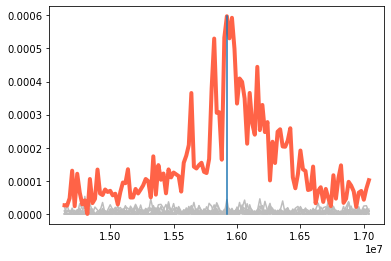

In [49]:
for s in tumour_samples:
    if s != sv_sample_id:
        plt.plot(
            np.linspace(j_tad[0], j_tad[1], mat[s]["BRAF"]["new"].shape[0]),
            np.mean(mat[s]["BRAF"]["new"], axis=1),
            color="#bdbdbd",
        )

plt.plot(
    np.linspace(j_tad[0], j_tad[1], mat[sv_sample_id]["BRAF"]["new"].shape[0]),
    np.mean(mat[sv_sample_id]["BRAF"]["new"], axis=1),
    color="#ff6347",
    linewidth=4,
)
plt.plot(
    [sv_coords[1], sv_coords[1]],
    [0, np.nanmax([np.nanmean(mat[s]["BRAF"]["new"], axis=1) for s in tumour_samples])],
)

In [18]:
mut_s = "PCa53687"

pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr7", 140275699, hg38),
        nc.chr_pos_to_genome_pos("chr7", 141295700, hg38),
    ],
    "y": [
        nc.chr_pos_to_genome_pos("chr19", 15451565, hg38),
        nc.chr_pos_to_genome_pos("chr19", 16304417, hg38),
    ]
}

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            peaks[mut_s]["top"],
        ],
        initialXDomain=pos["y"],
    ),
]

display, server, viewconf = higlass.display(
    views=v,
    zoom_syncs=[v],
    location_syncs=[v],
    server_port=8198
)

display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'Kywa3pkkS2ykc1DXhcOt2Q', 'tracks': {'top': [{'ty…

In [60]:
fig= plt.figure(
    figsize=(8 / 2.54, 6 / 2.54),
    dpi=300,
)

for s in tumour_samples:
    if s != sv_sample_id:
        plt.plot(
            np.linspace(i_tad[0], i_tad[1], mat[s]["DENND2A"]["old"].shape[0]),
            np.mean(mat[s]["DENND2A"]["old"], axis=1),
            color="#bdbdbd",
        )

plt.plot(
    np.linspace(i_tad[0], i_tad[1], mat[sv_sample_id]["DENND2A"]["old"].shape[0]),
    np.mean(mat[sv_sample_id]["DENND2A"]["old"], axis=1),
    color="#ff6347",
    linewidth=4,
)
plt.plot(
    [dennd2a_coords[0], dennd2a_coords[1]],
    [0, 0],
)
plt.plot(
    [sv_coords[0], sv_coords[0]],
    [0, np.nanmax([np.nanmean(mat[s]["DENND2A"]["old"], axis=1) for s in tumour_samples])],
)
fig.savefig("DENND2A-4C.pdf")
plt.close()

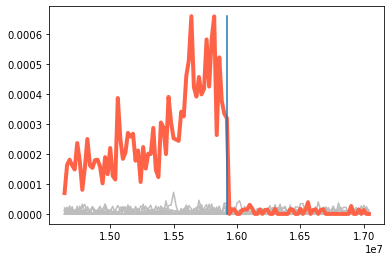

In [51]:
for s in tumour_samples:
    if s != sv_sample_id:
        plt.plot(
            np.linspace(j_tad[0], j_tad[1], mat[s]["DENND2A"]["new"].shape[0]),
            np.mean(mat[s]["DENND2A"]["new"], axis=1),
            color="#bdbdbd",
        )

plt.plot(
    np.linspace(j_tad[0], j_tad[1], mat[sv_sample_id]["DENND2A"]["new"].shape[0]),
    np.mean(mat[sv_sample_id]["DENND2A"]["new"], axis=1),
    color="#ff6347",
    linewidth=4,
)
plt.plot(
    [sv_coords[1], sv_coords[1]],
    [0, np.nanmax([np.nanmean(mat[s]["DENND2A"]["new"], axis=1) for s in tumour_samples])],
)